# Modelos de Deep Learning

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import warnings
warnings.filterwarnings("ignore")

In [104]:
df = pd.read_csv("https://raw.githubusercontent.com/lihkir/Data/refs/heads/main/Bitcoin%20Historical%20Data.csv", thousands=',', decimal='.')
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.sort_index(inplace=True)
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%
...,...,...,...,...,...,...
2024-03-20,67854.0,62046.8,68029.5,60850.9,133.53K,9.35%
2024-03-21,65503.8,67860.0,68161.7,64616.1,75.26K,-3.46%
2024-03-22,63785.5,65501.5,66633.3,62328.3,72.43K,-2.62%


In [105]:
# retorno acumulado
def retorno_acumulado(df, columna):
    retorno_diario = (df[columna].diff() / df[columna].shift(1))
    return retorno_diario.cumsum()

def volatilidad(retorno_acum, ventana):
    std_w = retorno_acum.rolling(window=ventana).std()
    return std_w


df["DailyReturn"] = retorno_acumulado(df, "Price")
df["Volatility"] =  volatilidad(df["DailyReturn"], 7)

df

,Price,Open,High,Low,Vol.,Change %,DailyReturn,Volatility
Date,,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,NaN,NaN
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.000000,NaN
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.000000,NaN
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.000000,NaN
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.000000,NaN
...,...,...,...,...,...,...,...,...
2024-03-20,67854.0,62046.8,68029.5,60850.9,133.53K,9.35%,23.719802,0.043620
2024-03-21,65503.8,67860.0,68161.7,64616.1,75.26K,-3.46%,23.685166,0.036828
2024-03-22,63785.5,65501.5,66633.3,62328.3,72.43K,-2.62%,23.658934,0.034760


In [106]:
timeserie  = df["Price"]

## Split de datos

In [15]:
def split_time_series(data, tau, train_nrows, train_ncols=0):
    """
    train_ncols: Número de columnas para el train
    train_nrows: Número de filas para el train
    tau: número de rows y cols para val y test
    """
    n_samples = len(data)
    len_dim = train_nrows + tau * 2  # total filas por dim
    train_ncols = tau
    splits = []
    id_counter = 1
    dim = 1
    split_counter = 0

    for start in range(n_samples):
        if split_counter == 0:
            if start + len_dim > n_samples:
                break  # No hay suficientes datos
        
        current_dim_start_idx = len(splits)
        
        x_train_end = start + train_ncols
        x_tau_end = start + tau


        # Determinar el tipo de split
        if split_counter < train_nrows:
            split_type = "train"
            X_data = data.iloc[start:x_train_end].values.copy()  # Tomar train_ncols columnas
            y_data = data.iloc[x_train_end:x_train_end +1 ].values.copy()  # y correspondiente a train_nrows
        elif split_counter < train_nrows + tau:
            split_type = "val"
            X_data = data.iloc[start:x_tau_end].values.copy()  # val: tau columnas
            y_data = data.iloc[x_tau_end:x_tau_end + 1].values.copy()  # y correspondiente al tau
        elif split_counter < len_dim:
            split_type = "test"
            X_data = data.iloc[start:x_tau_end].values.copy()  # test: tau columnas
            y_data = data.iloc[x_tau_end:x_tau_end + 1].values.copy()  # y correspondiente al tau
        else:
            dim += 1
            split_counter = 0
            split_type = "train"
            continue
        if len(y_data) == 0:
            break  # algún muestra no tiene y, por tanto, no consideremos este dim

        split_dict = {
            "id": id_counter,
            "dim": dim,
            "split": split_type,
            "X": X_data,
            "y": y_data
        }

        splits.append(split_dict)

        # Contadores
        id_counter += 1
        split_counter += 1

        if split_counter >= len_dim:
            dim += 1
            split_counter = 0

    df = pd.DataFrame(splits)
    dim_ok = df["dim"].value_counts() == len_dim
    df_ok = df.loc[df["dim"].isin(dim_ok[dim_ok].index)].copy()
    return df_ok

In [125]:
def split_time_series_with_indexes(data, tau, train_nrows, train_ncols=0):
    """
    Es exactamente la misma función, pero que regresa index
    """
    n_samples = len(data)
    len_dim = train_nrows + tau * 2  
    train_ncols = tau
    splits = []
    id_counter = 1
    dim = 1
    split_counter = 0

    for start in range(n_samples):
        if split_counter == 0:
            if start + len_dim > n_samples:
                break  # No hay suficientes datos
        
        current_dim_start_idx = len(splits)
        
        x_train_end = start + train_ncols
        x_tau_end = start + tau

        if split_counter < train_nrows:
            split_type = "train"
            X_data = data.iloc[start:x_train_end].index.values.copy()  
            y_data = data.iloc[x_train_end:x_train_end + 1].index.values.copy()  
        elif split_counter < train_nrows + tau:
            split_type = "val"
            X_data = data.iloc[start:x_tau_end].index.values.copy()  
            y_data = data.iloc[x_tau_end:x_tau_end + 1].index.values.copy()  
        elif split_counter < len_dim:
            split_type = "test"
            X_data = data.iloc[start:x_tau_end].index.values.copy()  
            y_data = data.iloc[x_tau_end:x_tau_end + 1].index.values.copy()  
        else:
            dim += 1
            split_counter = 0
            continue
        if len(y_data) == 0:
            break  

        split_dict = {
            "id": id_counter,
            "dim": dim,
            "split": split_type,
            "X": X_data,
            "y": y_data
        }

        splits.append(split_dict)

        # Contadores
        id_counter += 1
        split_counter += 1

        if split_counter >= len_dim:
            dim += 1
            split_counter = 0

    df = pd.DataFrame(splits)
    dim_ok = df["dim"].value_counts() == len_dim
    df_ok = df.loc[df["dim"].isin(dim_ok[dim_ok].index)].copy()
    return df_ok


def plot_time_series_splits(df, num_samples=None):
    """
    Grafica los intervalos de tiempo de X y y para cada fila del DataFrame.

    """
    if num_samples is not None:
        df = df.head(num_samples)

    fig, ax = plt.subplots(figsize=(10, len(df) * 0.3))

    for idx, row in df.iterrows():
        sample_id = row['id']
        X_times = row['X']
        y_time = row['y'][0]

        X_start = pd.to_datetime(X_times[0])
        X_end = pd.to_datetime(X_times[-1])

        y_time = pd.to_datetime(y_time)


        ax.hlines(y=idx, xmin=X_start, xmax=X_end, color='skyblue', linewidth=6, label='X' if idx == 0 else "")


        ax.plot(y_time, idx, 'ro', label='y' if idx == 0 else "")


    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df['split'] + ' ' + df['id'].astype(str))

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Muestras')
    ax.set_title('Intervalos de tiempo de X y y para cada muestra')


    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()


In [126]:
series_name = ["Price", "DailyReturn","Volatility"]
tau_list = [7,14,21,28]
train_lens = [7,14,21,28]

datasets_index = {}

for serie, tau, train_nrows in itertools.product(series_name, tau_list, train_lens):
    key = f"{serie}_tau{tau}_train_rows{train_nrows}"
    dataset = split_time_series_with_indexes(data=df[serie], tau=tau, train_nrows=train_nrows)
    datasets_index[key] = dataset

In [127]:
datasets_index.keys()

dict_keys(['Price_tau7_train_rows7', 'Price_tau7_train_rows14', 'Price_tau7_train_rows21', 'Price_tau7_train_rows28', 'Price_tau14_train_rows7', 'Price_tau14_train_rows14', 'Price_tau14_train_rows21', 'Price_tau14_train_rows28', 'Price_tau21_train_rows7', 'Price_tau21_train_rows14', 'Price_tau21_train_rows21', 'Price_tau21_train_rows28', 'Price_tau28_train_rows7', 'Price_tau28_train_rows14', 'Price_tau28_train_rows21', 'Price_tau28_train_rows28', 'DailyReturn_tau7_train_rows7', 'DailyReturn_tau7_train_rows14', 'DailyReturn_tau7_train_rows21', 'DailyReturn_tau7_train_rows28', 'DailyReturn_tau14_train_rows7', 'DailyReturn_tau14_train_rows14', 'DailyReturn_tau14_train_rows21', 'DailyReturn_tau14_train_rows28', 'DailyReturn_tau21_train_rows7', 'DailyReturn_tau21_train_rows14', 'DailyReturn_tau21_train_rows21', 'DailyReturn_tau21_train_rows28', 'DailyReturn_tau28_train_rows7', 'DailyReturn_tau28_train_rows14', 'DailyReturn_tau28_train_rows21', 'DailyReturn_tau28_train_rows28', 'Volatility_t

### Ejemplo 1: Price_tau14_train_rows7

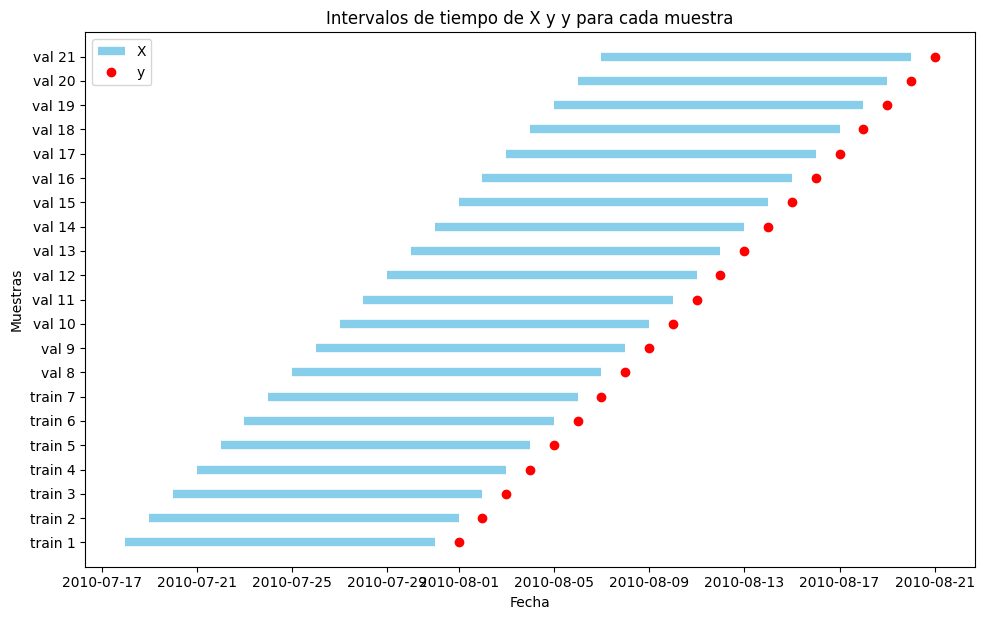

In [130]:
plot_time_series_splits(datasets_index.get("Price_tau14_train_rows7"), 21)

### Ejemplo 2: Price_tau14_train_rows7

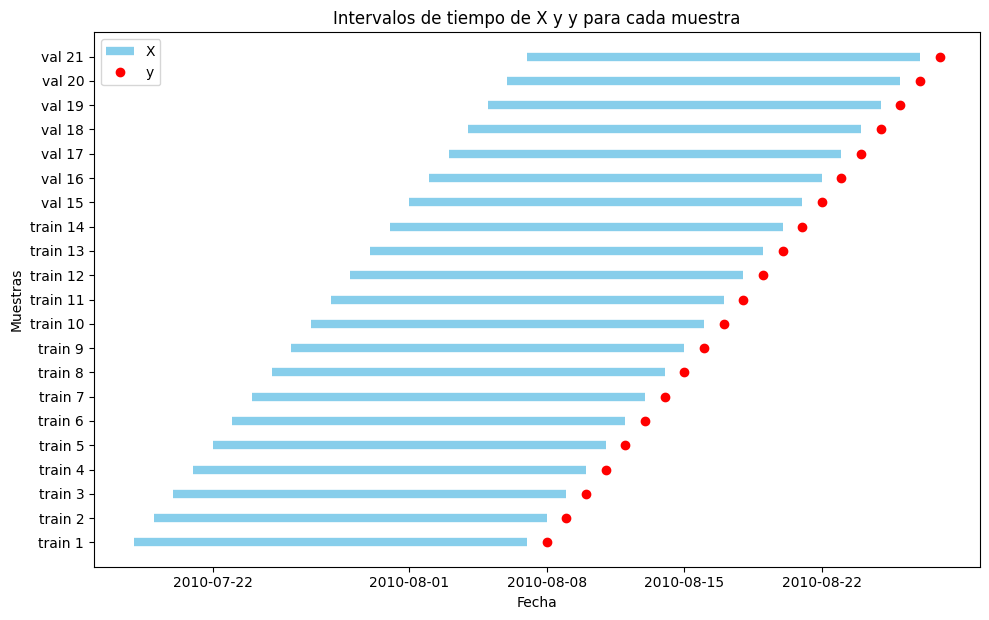

In [133]:
plot_time_series_splits(datasets_index.get("Volatility_tau21_train_rows14"), 21)

### Ejemplo 3: Price_tau14_train_rows7

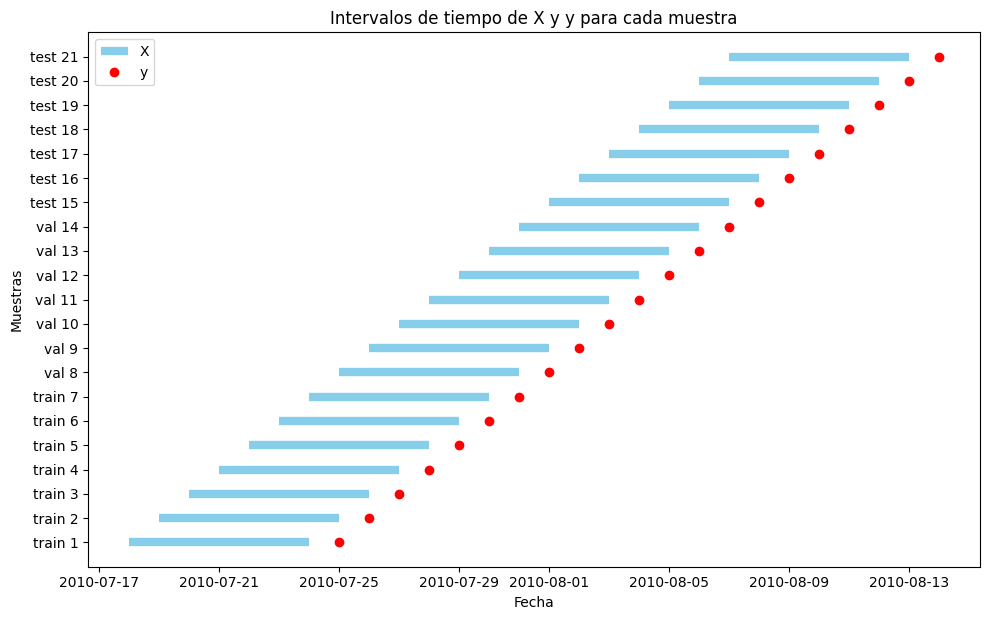

In [132]:
plot_time_series_splits(datasets_index.get("Price_tau7_train_rows7"), 21)

## Conjuntos de datos a evaluar

In [119]:
series_name = ["Price", "DailyReturn","Volatility"]
tau_list = [7,14,21,28]
train_lens = [7,14,21,28]

datasets = {}

for serie, tau, train_nrows in itertools.product(series_name, tau_list, train_lens):
    key = f"{serie}_tau{tau}_train_rows{train_nrows}"
    dataset = split_time_series(data=df[serie], tau=tau, train_nrows=train_nrows)
    datasets[key] = dataset

In [120]:
len(datasets.keys())

48

In [121]:
#Vemos uno de los datasets
df_model = datasets.get("Price_tau7_train_rows28")
df_model

,id,dim,split,X,y
0,1,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
1,2,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
2,3,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
3,4,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
4,5,1,train,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",[0.1]
...,...,...,...,...,...
4951,4952,118,test,"[43087.7, 44339.8, 45293.3, 47127.5, 47758.2, ...",[49716.0]
4952,4953,118,test,"[44339.8, 45293.3, 47127.5, 47758.2, 48277.3, ...",[51782.4]
4953,4954,118,test,"[45293.3, 47127.5, 47758.2, 48277.3, 49941.3, ...",[51901.3]
4954,4955,118,test,"[47127.5, 47758.2, 48277.3, 49941.3, 49716.0, ...",[52134.2]


In [14]:
count = 0
for key in datasets.keys():
    count += len(datasets.get(key).dim.unique())
    
print(f"Hay en total {count} pliegues (o 'dims') para entrenar los modelos")

Hay en total 5208 pliegues (o 'dims') para entrenar los modelos


## Entrenamiento y validación

### Un modelo (testing)

In [15]:
import keras.backend as K
import statsmodels.api as sm
import tensorflow as tf
from scipy import stats
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error, mean_squared_error,r2_score
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import jarque_bera
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using GPU.")
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU details: {gpu_details}")
else:
    print("TensorFlow is not using GPU.")

TensorFlow is using GPU.
GPU details: {'device_name': 'NVIDIA GeForce RTX 2060 SUPER', 'compute_capability': (7, 5)}


### Procesamiento por lotes Modelos

In [17]:
def plot_residuals(resid, save_path):
    """
    Genera y guarda una figura con tres subplots
    """
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    #Serie de Residuos
    axs[0].plot(resid, color='blue')
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title('Serie de Residuos')
    axs[0].set_xlabel('Índice')
    axs[0].set_ylabel('Residuo')

    #QQPlot de Residuos
    sm.qqplot(resid, line='s', ax=axs[1])
    axs[1].set_title('QQPlot de Residuos')

    #ACF de Residuos
    plot_acf(resid, ax=axs[2], lags=min(20, len(resid)-1))
    axs[2].set_title('ACF de Residuos')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


def create_and_train_model(model_type, neurons, dropout_rate, batch_size, X_train, y_train, X_val, y_val, key, dim):
    model = Sequential()
    if model_type == 'MLP':
        # (samples, features)
        model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'RNN':
        #(samples, timesteps, features)
        model.add(SimpleRNN(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    elif model_type == 'LSTM':
        #(samples, timesteps, features)
        model.add(LSTM(neurons, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

    else:
        raise ValueError("Modelo inválido")

    model.compile(optimizer=Adam(), loss='mse', metrics=['mape','mae', 'mse'])

    checkpoint_dir = f'models/{key}'
    os.makedirs(checkpoint_dir, exist_ok=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        f'{checkpoint_dir}/best_model_{model_type}_dim{dim}_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.h5',
        save_best_only=True,
        monitor='val_loss'
    )

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0,
        callbacks=[early_stopping, model_checkpoint]
    )
    return model, history

# Definición de la función para procesar y entrenar modelos
def process_and_train_models(key, df_model, model_types, neurons, dropout_rate, batch_size):
    """
    Procesa los datos para cada dim y entrena modelos de diferentes tipos.
    """
    resultados_entrenamiento = []
    resultados_test = []
    unique_dims = df_model["dim"].unique()

    for dim in unique_dims:
        df_dim = df_model.loc[df_model["dim"] == dim]

        # Procesar datos para entrenamiento, validación y prueba
        splits = {}
        for split in ["train", "val", "test"]:
            X_split, y_split = (
                df_dim.loc[df_dim["split"] == split, "X"].tolist(),
                df_dim.loc[df_dim["split"] == split, "y"].tolist()
            )
            X_split = np.array([np.array(xi).flatten() for xi in X_split])
            y_split = np.array([np.array(yi).flatten() for yi in y_split])
            splits[split] = (X_split, y_split)

        # Escalar los datos
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train, y_train = splits["train"]
        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

        X_val, y_val = splits["val"]
        X_val_scaled = scaler_X.transform(X_val)
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()

        X_test, y_test = splits["test"]
        X_test_scaled = scaler_X.transform(X_test)
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

        # Re-dimensionar para RNN/LSTM
        X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
        X_val_rnn = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
        X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

        # Actualizar splits con datos escalados
        splits_scaled = {
            "train": (X_train_scaled, y_train_scaled),
            "val": (X_val_scaled, y_val_scaled),
            "test": (X_test_scaled, y_test_scaled),
            "train_rnn": (X_train_rnn, y_train_scaled),
            "val_rnn": (X_val_rnn, y_val_scaled),
            "test_rnn": (X_test_rnn, y_test_scaled)
        }

        # Entrenar y evaluar modelos
        for model_type in model_types:
            try:
                if model_type in ['RNN', 'LSTM']:
                    X_train_model, y_train_model = splits_scaled["train_rnn"]
                    X_val_model, y_val_model = splits_scaled["val_rnn"]
                    X_test_model, y_test_model = splits_scaled["test_rnn"]
                elif model_type == 'MLP':
                    X_train_model, y_train_model = splits_scaled["train"]
                    X_val_model, y_val_model = splits_scaled["val"]
                    X_test_model, y_test_model = splits_scaled["test"]
                else:
                    raise ValueError(f"Tipo de modelo desconocido: {model_type}")

                # Entrenar el modelo
                model, history = create_and_train_model(
                    model_type=model_type,
                    neurons=neurons,
                    dropout_rate=dropout_rate,
                    batch_size=batch_size,
                    X_train=X_train_model,
                    y_train=y_train_model,
                    X_val=X_val_model,
                    y_val=y_val_model,
                    key=key,
                    dim=dim
                )
                
                history_dir = os.path.join('history', str(key))
                os.makedirs(history_dir, exist_ok=True)
                history_name = os.path.join(
                    history_dir,
                    f'historytrain_{model_type}_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
                    )
                history_df = pd.DataFrame(history.history)
                pd.DataFrame(history_df).to_csv(history_name, index=False)

                # Evaluar en el conjunto de entrenamiento
                y_train_pred = model.predict(X_train_model, verbose=0).flatten()
                residuals_train = y_train_model - y_train_pred

                mape_train = mean_absolute_percentage_error(y_train_model, y_train_pred)
                mae_train = mean_absolute_error(y_train_model, y_train_pred)
                mse_train = mean_squared_error(y_train_model, y_train_pred)
                rmse_train = root_mean_squared_error(y_train_model, y_train_pred)
                r2_train = r2_score(y_train_model, y_train_pred)
                
                jb_test = stats.jarque_bera(residuals_train)
                jarque_bera_p_value = jb_test[1]
                
                # Pruebas estadísticas en los residuos de entrenamiento
                max_lag = min(10, len(residuals_train) - 1)
                if max_lag >= 1:
                    ljung_box_result = acorr_ljungbox(residuals_train, lags=[max_lag], return_df=True)
                    ljung_box_pvalue = ljung_box_result['lb_pvalue'].values[0]
                else:
                    ljung_box_pvalue = np.nan

                # Guardar figuras
                fig_dir = f'figures/{key}/{model_type}'
                os.makedirs(fig_dir, exist_ok=True)

                residuals_plot_path = os.path.join(fig_dir, f'residuals_analysis_dim{dim}_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.png')
                plot_residuals(residuals_train, residuals_plot_path)

                # Almacenar los resultados en el conjunto de entrenamiento
                resultado_entrenamiento = {
                    "key": key,
                    "dim": dim,
                    "model_type": model_type,
                    "neurons": neurons,
                    "dropout_rate": dropout_rate,
                    "batch_size": batch_size,
                    "MAPE": mape_train,
                    "MAE": mae_train,
                    "RMSE": rmse_train,
                    "MSE": mse_train,
                    "R2": r2_train,
                    "Ljung_Box_pvalue": ljung_box_pvalue,
                    "Jarque_Bera_pvalue": jarque_bera_p_value
                }
                resultados_entrenamiento.append(resultado_entrenamiento)

                # Evaluar en el conjunto de prueba
                y_test_pred = model.predict(X_test_model, verbose=0).flatten()
                residuals_test = y_test_model - y_test_pred

                mape_test = mean_absolute_percentage_error(y_test_model, y_test_pred)
                mae_test = mean_absolute_error(y_test_model, y_test_pred)
                mse_test = mean_squared_error(y_test_model, y_test_pred)
                rmse_test = root_mean_squared_error(y_test_model, y_test_pred)
                r2_test = r2_score(y_test_model, y_test_pred)

                # Prueba de independencia en los residuos de prueba
                max_lag_test = min(10, len(residuals_test) - 1)
                if max_lag_test >= 1:
                    ljung_box_result_test = acorr_ljungbox(residuals_test, lags=[max_lag_test], return_df=True)
                    ljung_box_pvalue_test = ljung_box_result_test['lb_pvalue'].values[0]
                else:
                    ljung_box_pvalue_test = np.nan

                # Almacenar los resultados en el conjunto de prueba
                resultado_test = {
                    "key": key,
                    "dim": dim,
                    "model_type": model_type,
                    "neurons": neurons,
                    "dropout_rate": dropout_rate,
                    "batch_size": batch_size,
                    "MAPE": mape_test,
                    "MAE": mae_test,
                    "RMSE": rmse_test,
                    "MSE": mse_test,
                    "R2": r2_test,
                    "Ljung_Box_pvalue": ljung_box_pvalue_test
                }
                resultados_test.append(resultado_test)


                plt.figure()
                epochs = range(1, len(history.history['loss']) + 1)
                plt.plot(epochs, history.history['loss'], label='Loss Entrenamiento')
                plt.plot(epochs, history.history['val_loss'], label='Loss Validación')
                plt.title('Curva de Entrenamiento')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(f'{fig_dir}/training_history_dim{dim}_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.png')
                plt.close()

                # Liberar memoria
                del model, history, residuals_train, residuals_test
                gc.collect()
            except Exception as e:
                print(f"Error al entrenar {model_type} para key={key}, dim={dim}: {e}")
                continue
    try:
        results_dir = f'results/{key}'
        os.makedirs(results_dir, exist_ok=True)
        
        train_csv_path = f'{results_dir}/results_train_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
        test_csv_path = f'{results_dir}/results_test_neurons{neurons}_dropout{dropout_rate}_batch{batch_size}.csv'
        
        pd.DataFrame(resultados_entrenamiento).to_csv(train_csv_path, index=False)
        pd.DataFrame(resultados_test).to_csv(test_csv_path, index=False)
        print(f"Entrenamiento exitoso para key={key}, neurons={neurons}, dropout={dropout_rate}, batch_size={batch_size}.")
        return {
            "key": key,
            "neurons": neurons,
            "dropout_rate": dropout_rate,
            "batch_size": batch_size,
            "status": "success",
            "results_dir": results_dir
        }
    except Exception as e:
        print(f"Error al guardar resultados para key={key}, neurons={neurons}, dropout={dropout_rate}, batch_size={batch_size}: {e}")
        return {
            "key": key,
            "neurons": neurons,
            "dropout_rate": dropout_rate,
            "batch_size": batch_size,
            "status": "failed",
            "error": str(e)
        }

### Ejecución loop

In [18]:
datasets.keys()

dict_keys(['Price_tau7_train_rows7', 'Price_tau7_train_rows14', 'Price_tau7_train_rows21', 'Price_tau7_train_rows28', 'Price_tau14_train_rows7', 'Price_tau14_train_rows14', 'Price_tau14_train_rows21', 'Price_tau14_train_rows28', 'Price_tau21_train_rows7', 'Price_tau21_train_rows14', 'Price_tau21_train_rows21', 'Price_tau21_train_rows28', 'Price_tau28_train_rows7', 'Price_tau28_train_rows14', 'Price_tau28_train_rows21', 'Price_tau28_train_rows28', 'DailyReturn_tau7_train_rows7', 'DailyReturn_tau7_train_rows14', 'DailyReturn_tau7_train_rows21', 'DailyReturn_tau7_train_rows28', 'DailyReturn_tau14_train_rows7', 'DailyReturn_tau14_train_rows14', 'DailyReturn_tau14_train_rows21', 'DailyReturn_tau14_train_rows28', 'DailyReturn_tau21_train_rows7', 'DailyReturn_tau21_train_rows14', 'DailyReturn_tau21_train_rows21', 'DailyReturn_tau21_train_rows28', 'DailyReturn_tau28_train_rows7', 'DailyReturn_tau28_train_rows14', 'DailyReturn_tau28_train_rows21', 'DailyReturn_tau28_train_rows28', 'Volatility_t

In [19]:
def configure_tf():
    K.set_floatx('float16')
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        try:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, False)
        except RuntimeError as e:
            print(e)

if __name__ == "__main__":
    # Configurar TensorFlow
    configure_tf()

    #listas de parámetros
    keys = ["Price_tau7_train_rows14"] #datasets.keys()
    neurons_list = [10, 100]
    dropout_rate_list = [0.2, 0.4, 0.6, 0.8]
    batch_size_list = [16, 32, 64, 128]
    model_types = [
        'MLP',
        'RNN',
        'LSTM'
        ]

    all_combinations = list(itertools.product(keys, neurons_list, dropout_rate_list, batch_size_list))
    all_results = []

    # Procesar cada configuración
    for combo in all_combinations:
        key, neurons, dropout_rate, batch_size = combo
        df_model = datasets.get(key)
        df_model = df_model.loc[df_model["dim"].isin(df_model["dim"].unique())]
        result = process_and_train_models(key, df_model, model_types, neurons, dropout_rate,batch_size)
        all_results.append(result)

Entrenamiento exitoso para key=Price_tau7_train_rows14, neurons=10, dropout=0.2, batch_size=16.
Entrenamiento exitoso para key=Price_tau7_train_rows14, neurons=10, dropout=0.2, batch_size=32.


KeyboardInterrupt: 

## Leer y resumir los resultados obtenidos

Lo resultados de la impmenentación se extreen en archivos apartes, por tanto, se leen para presentarlos.

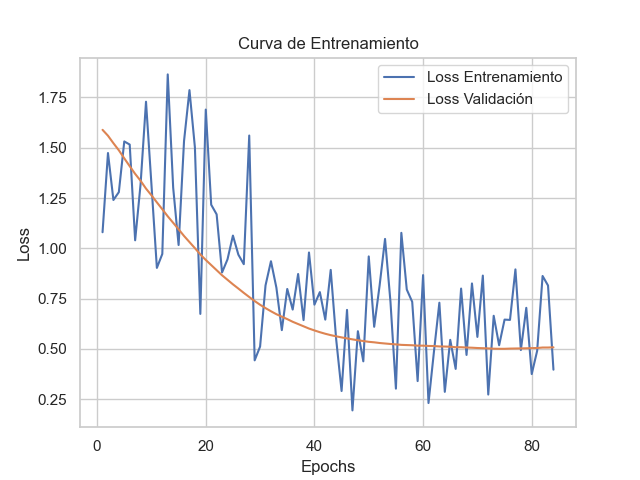

In [149]:
from IPython.display import Image
Image(filename='../../../figures/Price_tau7_train_rows7/RNN/training_history_dim214_neurons10_dropout0.2_batch128.png')

In [154]:
from pathlib import Path
ruta_results = Path('../../../figures')
lista_pngs = []

for archivo in ruta_results.rglob('*.png'):
    lista_pngs.append(archivo)


print(f"Hay en total {len(lista_pngs)} imágenes generadas como parte de los resultados")

Hay en total 9996 imágenes generadas


In [155]:
ruta_results = Path('../../../models')
lista_modelos = []

for archivo in ruta_results.rglob('*.h5'):
    lista_modelos.append(archivo)


print(f"Y {len(lista_modelos)} modelos (mejores) entrendados para todos los pliegues evaluados")

Y 5000 modelos (mejores) entrendados en cada pliegue


In [70]:

ruta_results = Path('../../../results')
lista_dfs = []

for archivo in ruta_results.rglob('*.csv'):
    df = pd.read_csv(archivo)
    df['nombre_archivo'] = archivo.name
    df["split"] = df["nombre_archivo"].str.split("_",expand=True)[1]
    lista_dfs.append(df)

todos_resultados = pd.concat(lista_dfs, ignore_index=True)

In [71]:
todos_resultados

,key,dim,model_type,neurons,dropout_rate,batch_size,MAPE,MAE,RMSE,MSE,R2,Ljung_Box_pvalue,nombre_archivo,split,Jarque_Bera_pvalue
0,Price_tau7_train_rows14,1,MLP,10,0.2,16,0.062500,1.387779e-17,1.387779e-17,1.925930e-34,0.000000,NaN,results_test_neurons10_dropout0.2_batch16.csv,test,NaN
1,Price_tau7_train_rows14,1,RNN,10,0.2,16,0.062500,1.387779e-17,1.387779e-17,1.925930e-34,0.000000,NaN,results_test_neurons10_dropout0.2_batch16.csv,test,NaN
2,Price_tau7_train_rows14,1,LSTM,10,0.2,16,0.062500,1.387779e-17,1.387779e-17,1.925930e-34,0.000000,NaN,results_test_neurons10_dropout0.2_batch16.csv,test,NaN
3,Price_tau7_train_rows14,2,MLP,10,0.2,16,0.062500,1.387779e-17,1.387779e-17,1.925930e-34,0.000000,NaN,results_test_neurons10_dropout0.2_batch16.csv,test,NaN
4,Price_tau7_train_rows14,2,RNN,10,0.2,16,0.062500,1.387779e-17,1.387779e-17,1.925930e-34,0.000000,NaN,results_test_neurons10_dropout0.2_batch16.csv,test,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7819,Price_tau7_train_rows7,236,RNN,10,0.2,64,1.338048,8.436060e-01,1.101342e+00,1.212955e+00,-0.212955,0.448480,results_train_neurons10_dropout0.2_batch64.csv,train,0.920366
7820,Price_tau7_train_rows7,236,LSTM,10,0.2,64,0.915076,7.498092e-01,1.083016e+00,1.172923e+00,-0.172923,0.813940,results_train_neurons10_dropout0.2_batch64.csv,train,0.618632
7821,Price_tau7_train_rows7,237,MLP,10,0.2,64,1.865902,1.295625e+00,1.692792e+00,2.865545e+00,-1.865545,0.325724,results_train_neurons10_dropout0.2_batch64.csv,train,0.766119
7822,Price_tau7_train_rows7,237,RNN,10,0.2,64,1.039190,5.174645e-01,5.805962e-01,3.370920e-01,0.662908,0.401982,results_train_neurons10_dropout0.2_batch64.csv,train,0.709055


In [145]:
todos_resultados_gpd = todos_resultados.groupby(["key","split","model_type","neurons","dropout_rate","batch_size"]).mean(numeric_only=True).reset_index().sort_values(by="MSE")
todos_resultados_gpd

,key,split,model_type,neurons,dropout_rate,batch_size,dim,MAPE,MAE,RMSE,MSE,R2,Ljung_Box_pvalue,Jarque_Bera_pvalue
7,Price_tau7_train_rows14,train,LSTM,10,0.2,32,89.5,1.640069e+10,0.570782,0.713008,0.567864,4.152824e-01,0.324494,0.570640
26,Price_tau7_train_rows7,train,LSTM,10,0.2,64,119.0,3.868254e+12,0.580494,0.705985,0.584924,3.939789e-01,0.421745,0.672706
24,Price_tau7_train_rows7,train,LSTM,10,0.2,16,119.0,4.765221e+12,0.564528,0.701913,0.586621,3.922815e-01,0.409995,0.678913
25,Price_tau7_train_rows7,train,LSTM,10,0.2,32,119.0,2.771815e+12,0.563857,0.695044,0.586977,3.919264e-01,0.429769,0.665735
27,Price_tau7_train_rows7,train,LSTM,10,0.2,128,119.0,4.945638e+12,0.574020,0.704980,0.589891,3.890116e-01,0.418694,0.683853
6,Price_tau7_train_rows14,train,LSTM,10,0.2,16,89.5,5.078487e+10,0.577718,0.719705,0.596817,3.863289e-01,0.318590,0.557428
11,Price_tau7_train_rows14,train,RNN,10,0.2,32,89.5,4.461076e+10,0.588200,0.726087,0.606890,3.762559e-01,0.336193,0.608993
10,Price_tau7_train_rows14,train,RNN,10,0.2,16,89.5,2.364123e+10,0.607759,0.752340,0.649637,3.335089e-01,0.348555,0.599527
33,Price_tau7_train_rows7,train,RNN,10,0.2,32,119.0,6.375358e+12,0.609986,0.740762,0.680827,2.980756e-01,0.402293,0.713309
34,Price_tau7_train_rows7,train,RNN,10,0.2,64,119.0,6.833647e+12,0.627721,0.747502,0.683796,2.951068e-01,0.355101,0.710847


<Axes: xlabel='model_type', ylabel='MSE'>

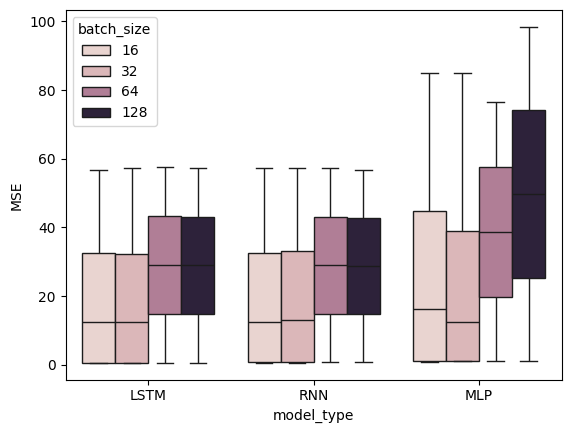

In [147]:
sns.boxplot(data=todos_resultados_gpd, x="model_type", y="MSE", hue="batch_size")

In [90]:
ruta_results = Path('../../../history')
lista_dfs = []

for archivo in ruta_results.rglob('*.csv'):
    df = pd.read_csv(archivo)
    df['nombre_archivo'] = archivo.name
    df['model_type'] = df["nombre_archivo"].str.split("_",expand=True)[1]
    df['neurons'] = df["nombre_archivo"].str.split("_",expand=True)[2]
    df['dropout'] = df["nombre_archivo"].str.split("_",expand=True)[3]
    df['batchsize'] = df["nombre_archivo"].str.split("_",expand=True)[4].str.split(".",expand=True)[0]
    #df["split"] = df["nombre_archivo"].str.split("_",expand=True)[1]
    lista_dfs.append(df)

history_results = pd.concat(lista_dfs, ignore_index=True)

In [134]:
history_results

,loss,mape,mae,mse,val_loss,val_mape,val_mae,val_mse,nombre_archivo,model_type,neurons,dropout,batchsize
0,0.933105,92.4375,0.867188,0.933105,1.713867,48.40625,1.232422,1.713867,historytrain_LSTM_neurons10_dropout0.2_batch16...,LSTM,neurons10,dropout0.2,batch16
1,2.074219,200.6250,1.180664,2.074219,1.791016,49.84375,1.264648,1.791016,historytrain_LSTM_neurons10_dropout0.2_batch16...,LSTM,neurons10,dropout0.2,batch16
2,1.952148,189.3750,1.147461,1.952148,2.207031,56.50000,1.420898,2.207031,historytrain_LSTM_neurons10_dropout0.2_batch16...,LSTM,neurons10,dropout0.2,batch16
3,1.716797,178.2500,1.106445,1.716797,2.490234,60.65625,1.517578,2.490234,historytrain_LSTM_neurons10_dropout0.2_batch16...,LSTM,neurons10,dropout0.2,batch16
4,1.634766,182.1250,1.083984,1.634766,2.921875,66.37500,1.653320,2.921875,historytrain_LSTM_neurons10_dropout0.2_batch16...,LSTM,neurons10,dropout0.2,batch16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,0.605469,2628.0000,0.604980,0.605469,4.210938,88.00000,1.658203,4.210938,historytrain_RNN_neurons10_dropout0.4_batch16.csv,RNN,neurons10,dropout0.4,batch16
1144,0.379395,1870.0000,0.536621,0.379395,4.207031,88.31250,1.659180,4.207031,historytrain_RNN_neurons10_dropout0.4_batch16.csv,RNN,neurons10,dropout0.4,batch16
1145,0.593750,3438.0000,0.705566,0.593750,4.195312,88.37500,1.659180,4.195312,historytrain_RNN_neurons10_dropout0.4_batch16.csv,RNN,neurons10,dropout0.4,batch16
1146,0.183960,995.0000,0.367676,0.183960,4.191406,88.56250,1.659180,4.191406,historytrain_RNN_neurons10_dropout0.4_batch16.csv,RNN,neurons10,dropout0.4,batch16


<Axes: xlabel='model_type', ylabel='mse'>

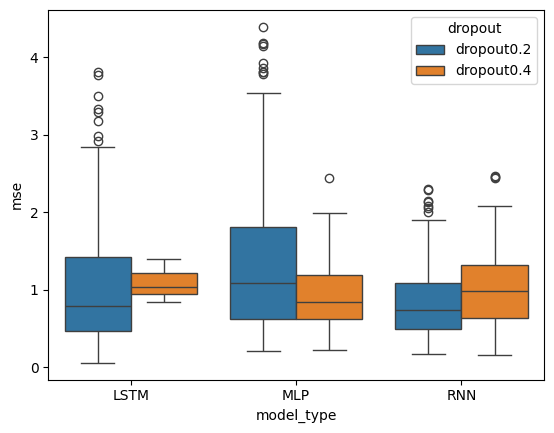

In [138]:
sns.boxplot(data=history_results, x="model_type", y="mse", hue="dropout")